# Classification of Traffic Sign using Deep Learning

# Data Preprocessing

---

### For testing: Don't run the preprocessing cells, it may take upto an hour to iterate through folders and add to the array. I've saved the pickle files which you need to set directory in the "Importing Pickle files" cell to test the notebook quickly.

---

## Installling packages to access google drive

The dataset is uploaded to google drive in a folder named "dataset", so mounting drive to access and load the dataset.

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls "/content/drive/My Drive/ML-Assignment"

dataset		dataset-shapes-augmented  sign_aug
dataset-shapes	dataset-sign-augmented


## Loading the Dataset (Original as given: unaugmented)

* Firstly, the original directory structure has been modified.

* The root directory consists of all directories of signs which now directly have all the images(just removed the all the sign folders from the shapes folders). 

* The PIL library is used to copy all the image content into an array name training_data. The dataset directory is specified and an array of categories is created that consists of the shapes.

* Although the provided images were already grayscale, but their shape had 3 channels, so I converted it's channel to 1.

* Below is one sample sign image and shape of it's array.

* This cell just iterates through the folder and returns the first image, this was just to verify the function.

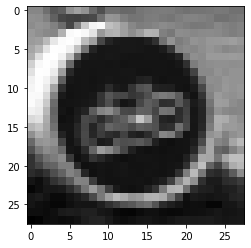

In [0]:
import numpy as np # to perform array operations
import matplotlib.pyplot as plt # to display images
import os # to iterate through directories and join paths
import cv2 # to perform image operations

DATADIR = "/content/drive/My Drive/ML-Assignment/dataset"
CATEGORIES = ["bicycle", "continue", "crossing", "giveway", "laneend", "limitedtraffic", "noentry", "noparking", "parking", "rightofway", "roundabout", "speed", "stop", "trafficdirective", "traveldirection", "warning"]

for category in CATEGORIES:
  path = os.path.join(DATADIR, category)
  for img in os.listdir(path):
    #Grayscale to make the array 2D
    img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_array, cmap="gray")
    plt.show()
    break
  break

In [0]:
print(img_array.shape)

(28, 28)


## Appending images and labels to an array

* The **"dataset"** directory contains 16 folders each representing a different class/category of sign.

* Using the OS module, the loop iterates over all the classes and append images and their corresponding labels in the **training_data** array.

In [0]:
training_data = []

def create_training_data():
  for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    print(category)
    for img in os.listdir(path):
      try:
        class_num = CATEGORIES.index(category)
        #Grayscale to make the array 2D
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        training_data.append([img_array, class_num])
        
      except Exception as e:
        pass

create_training_data()

bicycle
continue
crossing
giveway
laneend
limitedtraffic
noentry
noparking
parking
rightofway
roundabout
speed
stop
trafficdirective
traveldirection
warning


## Pickle data


Pickling data is basically to serialize and deserialize any python objects to byte streams. Here, I'm pickling the training_data list so that I can unpick the byte stream whenever required. The kernel clears all the data and variables each time it is restarted and the data needs to be loaded to memory everytime which is very time consuming.

* Saving all the raw pixel data of the sign images in a 4D array named **"feature.pickle"** which consists of (No. of images, width, height, colour channels)

* Saving index of categories that maps to each images in a 1D array named **"labels.pickle"**


In [0]:
import random

# Shuffling the data
random.shuffle(training_data)

X = []
y = []

IMG_SIZE = 28

for features, label in training_data:
  X.append(features)
  y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

y = np.array(y)

In [0]:
import pickle

pickle_out = open("features.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("labels.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

# Importing the Pickled files

---

### Run everthing from here, upload the pickle files if using google colab, or save the pickle files in the same directory and run the notebook cells

---

In [0]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

# Classes/categories to which all the images belong
CATEGORIES = ["bicycle", "continue", "crossing", "giveway", "laneend", "limitedtraffic", "noentry", "noparking", "parking", "rightofway", "roundabout", "speed", "stop", "trafficdirective", "traveldirection", "warning"]

In [0]:
pickle_in = open("features.pickle", "rb")
features = pickle.load(pickle_in)

In [0]:
pickle_in = open("labels.pickle", "rb")
labels = pickle.load(pickle_in)

## Normalizing the data

* Data normalization is very essential step in building an image classifier to make sure that each input pixel has a similar distribution of data.

* As I want all the pixel numbers to be positive so I scaled it between the range 0 to 255 by dividing every image data by 255.

* This will further make the convergence faster while training the network.


In [5]:
features = features/255.0
print("Features shape: ", features.shape)
print("Labels shape: ", labels.shape)

Features shape:  (3709, 28, 28, 1)
Labels shape:  (3709,)


# Splitting the data into Train, Validation and Test set



* The **Training set** is used to train the actual model. **75%** of the data is used for training.

* The **Validation set** is used to give us biased evaluation of the trained model. **15%** of data is used for validation.

* The **Test set** is unseen by the model while training, so it is used for the final evaluation of the model. **10%** data is used for testing.

In [6]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

print("Shapes of the dataframes")
print("Number of images and labels before splitting:",features.shape[0])
print("---------------------------------------------------------------------------------")
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size= 1 - train_ratio)
features_val, features_test, labels_val, labels_test = train_test_split(features_test, labels_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print("Number of training features/images:", features_train.shape[0])
print("Number of validation features/images:", features_val.shape[0])
print("Number of test features/images:", features_test.shape[0])

print("---------------------------------------------------------------------------------")

print("Number of training labels:", labels_train.shape[0])
print("Number of validation labels:", labels_val.shape[0])
print("Number of test labels:", labels_test.shape[0])

Using TensorFlow backend.


Shapes of the dataframes
Number of images and labels before splitting: 3709
---------------------------------------------------------------------------------
Number of training features/images: 2781
Number of validation features/images: 556
Number of test features/images: 372
---------------------------------------------------------------------------------
Number of training labels: 2781
Number of validation labels: 556
Number of test labels: 372


In [7]:
classes = len(set(labels_train))
print("Number of signs to classify: ", classes)

Number of signs to classify:  16


# Exploratory Analysis

---

* Building Histograms of the data to undertand the distribution of the data in training, validation and testing sets.

* Below is the function to plot histograms using seaborn library.

---



In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def plot_sns_histogram(y, CATEGORIES, count_plot_name=None):
    sign_dict = dict(zip([idx for idx in range(len(CATEGORIES))], CATEGORIES))
    y_labels = list(map(lambda sign_num : CATEGORIES[sign_num], y))
    y_df = pd.DataFrame(y_labels, dtype=str, columns=['CATEGORIES'])
    cnt_plot = sns.factorplot(x=y_labels, data=y_df, kind='count', size=7, aspect=1.2, palette='Set3')
    cnt_plot.set_xlabels('Traffic sign classes/categories')
    cnt_plot.fig.suptitle(count_plot_name, size=20)
    plt.xticks(
      rotation=45, 
      horizontalalignment='right',
      fontweight='light',
      fontsize='x-large'  
   )

    print("------------------------------")
    print('Categories          Counts')
    print("------------------------------")
    print(y_df['CATEGORIES'].value_counts())
    print("------------------------------")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Distribution of Training set

------------------------------
Categories          Counts
------------------------------
warning             523
noentry             281
speed               236
rightofway          219
bicycle             214
parking             213
noparking           187
giveway             181
continue            152
trafficdirective    144
traveldirection      97
limitedtraffic       89
laneend              83
roundabout           69
crossing             69
stop                 24
Name: CATEGORIES, dtype: int64
------------------------------


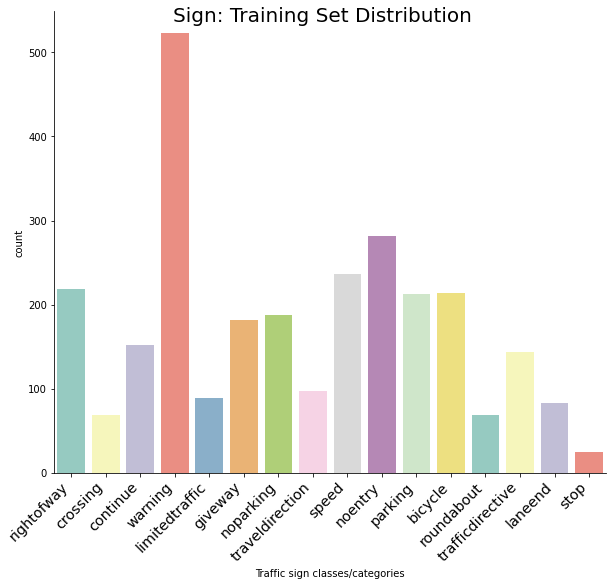

In [9]:
plot_sns_histogram(labels_train, CATEGORIES, 'Sign: Training Set Distribution')

## Distribution of Validation set

------------------------------
Categories          Counts
------------------------------
warning             121
noentry              55
speed                43
bicycle              39
parking              37
rightofway           34
trafficdirective     32
continue             30
noparking            30
giveway              29
laneend              23
traveldirection      20
limitedtraffic       20
roundabout           18
crossing             15
stop                 10
Name: CATEGORIES, dtype: int64
------------------------------


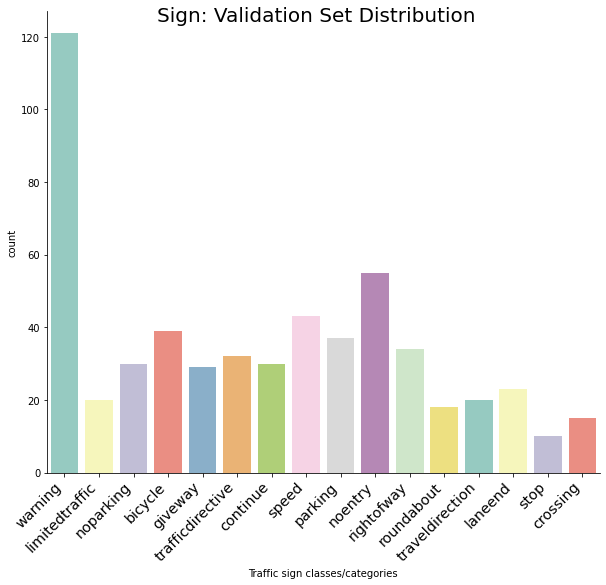

In [10]:
plot_sns_histogram(labels_val, CATEGORIES, 'Sign: Validation Set Distribution')

## Distribution of Test set

------------------------------
Categories          Counts
------------------------------
warning             51
noentry             39
speed               37
bicycle             32
rightofway          29
parking             26
noparking           25
giveway             21
trafficdirective    19
continue            17
traveldirection     17
limitedtraffic      16
laneend             12
roundabout          11
crossing            11
stop                 9
Name: CATEGORIES, dtype: int64
------------------------------


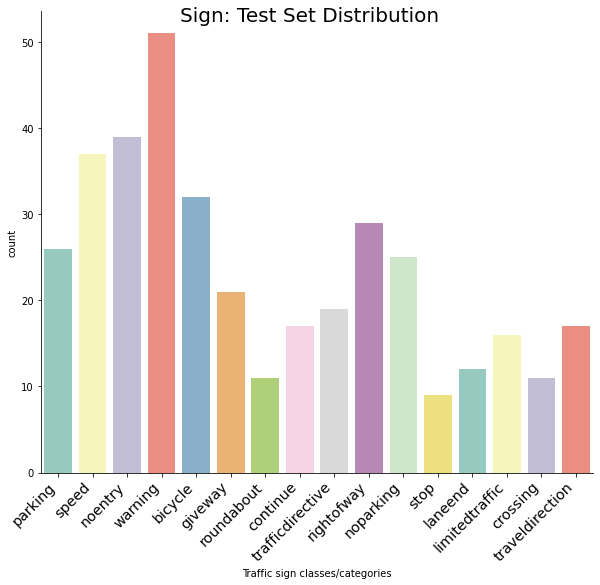

In [11]:
plot_sns_histogram(labels_test, CATEGORIES, 'Sign: Test Set Distribution')

## Exploratory visualization of the traffic sign images

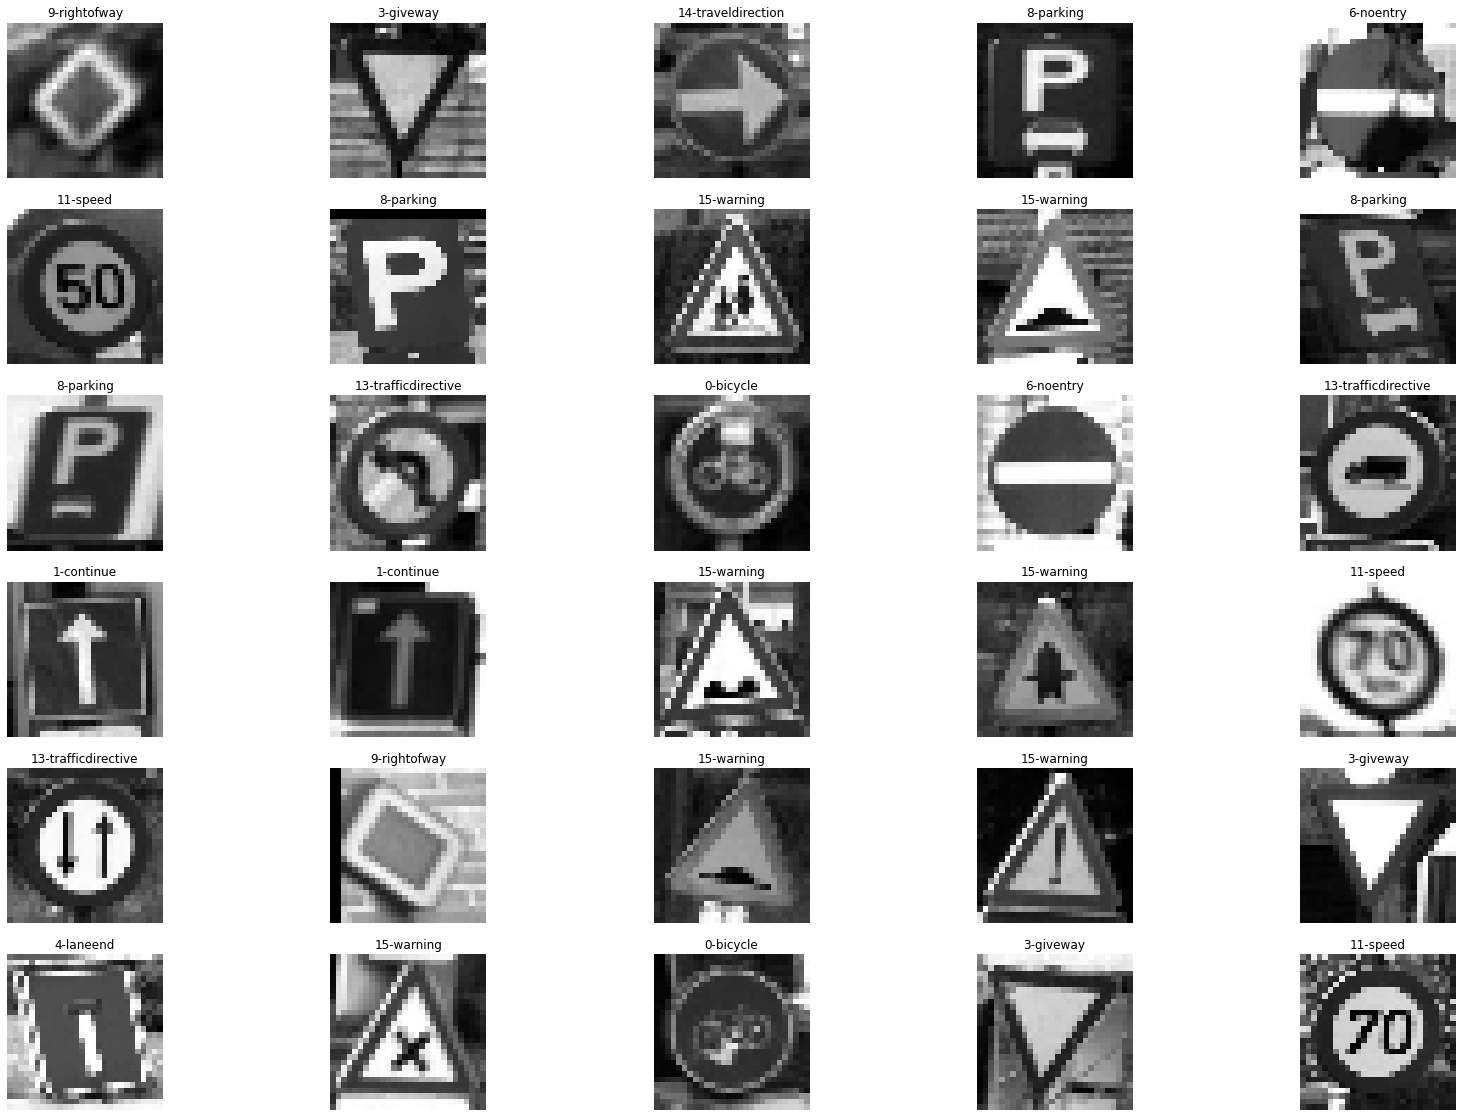

In [9]:
import random
import matplotlib.image
row_show, col_show = [6, 5]
fig, axes = plt.subplots(row_show, col_show, figsize=(28,20))
axes = axes.ravel()

for i in range(row_show * col_show):
    features_train1 = np.squeeze(features_train)
    index = random.randint(0, len(features_train1))
    image = features_train1[index]
    axes[i].imshow(image, cmap="gray")
    axes[i].set_title(str(labels_train[index]) + '-' + CATEGORIES[labels_train[index]])
    axes[i].axis('off')

# Designing the architecture of Covolutional Neural Network

In [0]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

## Configuration and execution pipeline

In [0]:
# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution
# 1st argument is number of feature dectectors=64
# 2nd argument is dimension of the feature map=(3,3)
# 3rd argument is input shape 28x28 and 1=grayscale
# 4th argument is the relu activation function to remove any negative pixel values
# from the feature maps in order to have non-linearity in the model
classifier.add(Conv2D(64, (3, 3), input_shape = (28, 28, 1), activation = 'relu'))

# Step 2 - Pooling
# we are preserving the features(i.e. if the image is twisted or flipped it still preserves the pattern)
# introducing spatial invariants
# reducing the size by 75%
# reducing number of parameters
# Hence, preventing overfitting
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 256, activation = 'relu'))
classifier.add(Dense(16, activation='softmax'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

## Fitting the model to train the classifier

In [12]:
history = classifier.fit(features_train, labels_train, batch_size=64, epochs=20, validation_data=(features_test, labels_test))
classifier.save("sign-classifier.h5")

Train on 2781 samples, validate on 372 samples
Epoch 1/20
2781/2781 [==============================] - 6s 2ms/step - loss: 1.8224 - accuracy: 0.4786 - val_loss: 0.8656 - val_accuracy: 0.8065
Epoch 2/20
2781/2781 [==============================] - 0s 79us/step - loss: 0.5129 - accuracy: 0.8662 - val_loss: 0.2959 - val_accuracy: 0.9516
Epoch 3/20
2781/2781 [==============================] - 0s 68us/step - loss: 0.2635 - accuracy: 0.9342 - val_loss: 0.2040 - val_accuracy: 0.9543
Epoch 4/20
2781/2781 [==============================] - 0s 65us/step - loss: 0.1525 - accuracy: 0.9619 - val_loss: 0.1411 - val_accuracy: 0.9758
Epoch 5/20
2781/2781 [==============================] - 0s 68us/step - loss: 0.1053 - accuracy: 0.9720 - val_loss: 0.1022 - val_accuracy: 0.9812
Epoch 6/20
2781/2781 [==============================] - 0s 66us/step - loss: 0.0801 - accuracy: 0.9791 - val_loss: 0.1102 - val_accuracy: 0.9731
Epoch 7/20
2781/2781 [==============================] - 0s 72us/step - loss: 0.0702 

In [13]:
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               409856    
_________________________________________________________________
dense_2 (Dense)              (None, 16)               

## Visualizing training-validation accuracy and training loss

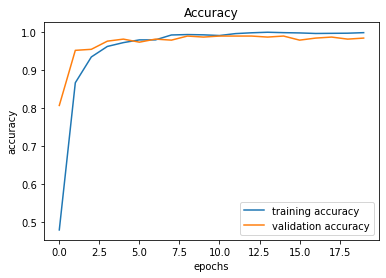

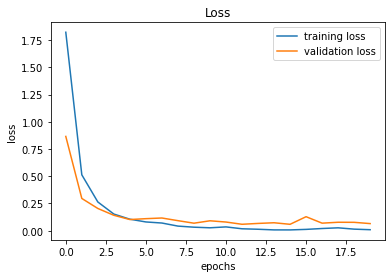

In [14]:
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## Prediction accuracy

In [15]:
from sklearn.metrics import accuracy_score

pred = classifier.predict_classes(features_test)
print(accuracy_score(labels_test, pred))

0.9838709677419355


## Analysis report

In [16]:
# Look at accuracy on test dataset by class label
import itertools
import numpy as np
from sklearn.metrics import classification_report

# print(len(labels_test), len(pred))
# print(labels_test[:10], pred[:10])
print("------------------------------------------------------")
print(classification_report(labels_test, pred))
print("------------------------------------------------------")

------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        26
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00         9
           3       1.00      0.91      0.95        23
           4       1.00      1.00      1.00        10
           5       0.91      0.91      0.91        11
           6       1.00      0.97      0.98        32
           7       0.96      1.00      0.98        26
           8       1.00      1.00      1.00        32
           9       0.93      1.00      0.97        28
          10       0.89      0.89      0.89         9
          11       1.00      1.00      1.00        42
          12       1.00      0.75      0.86         4
          13       1.00      1.00      1.00        25
          14       1.00      1.00      1.00        14
          15       1.00      1.00      1.00        66

    accuracy             

# Evaluating the model performance by unseen test data

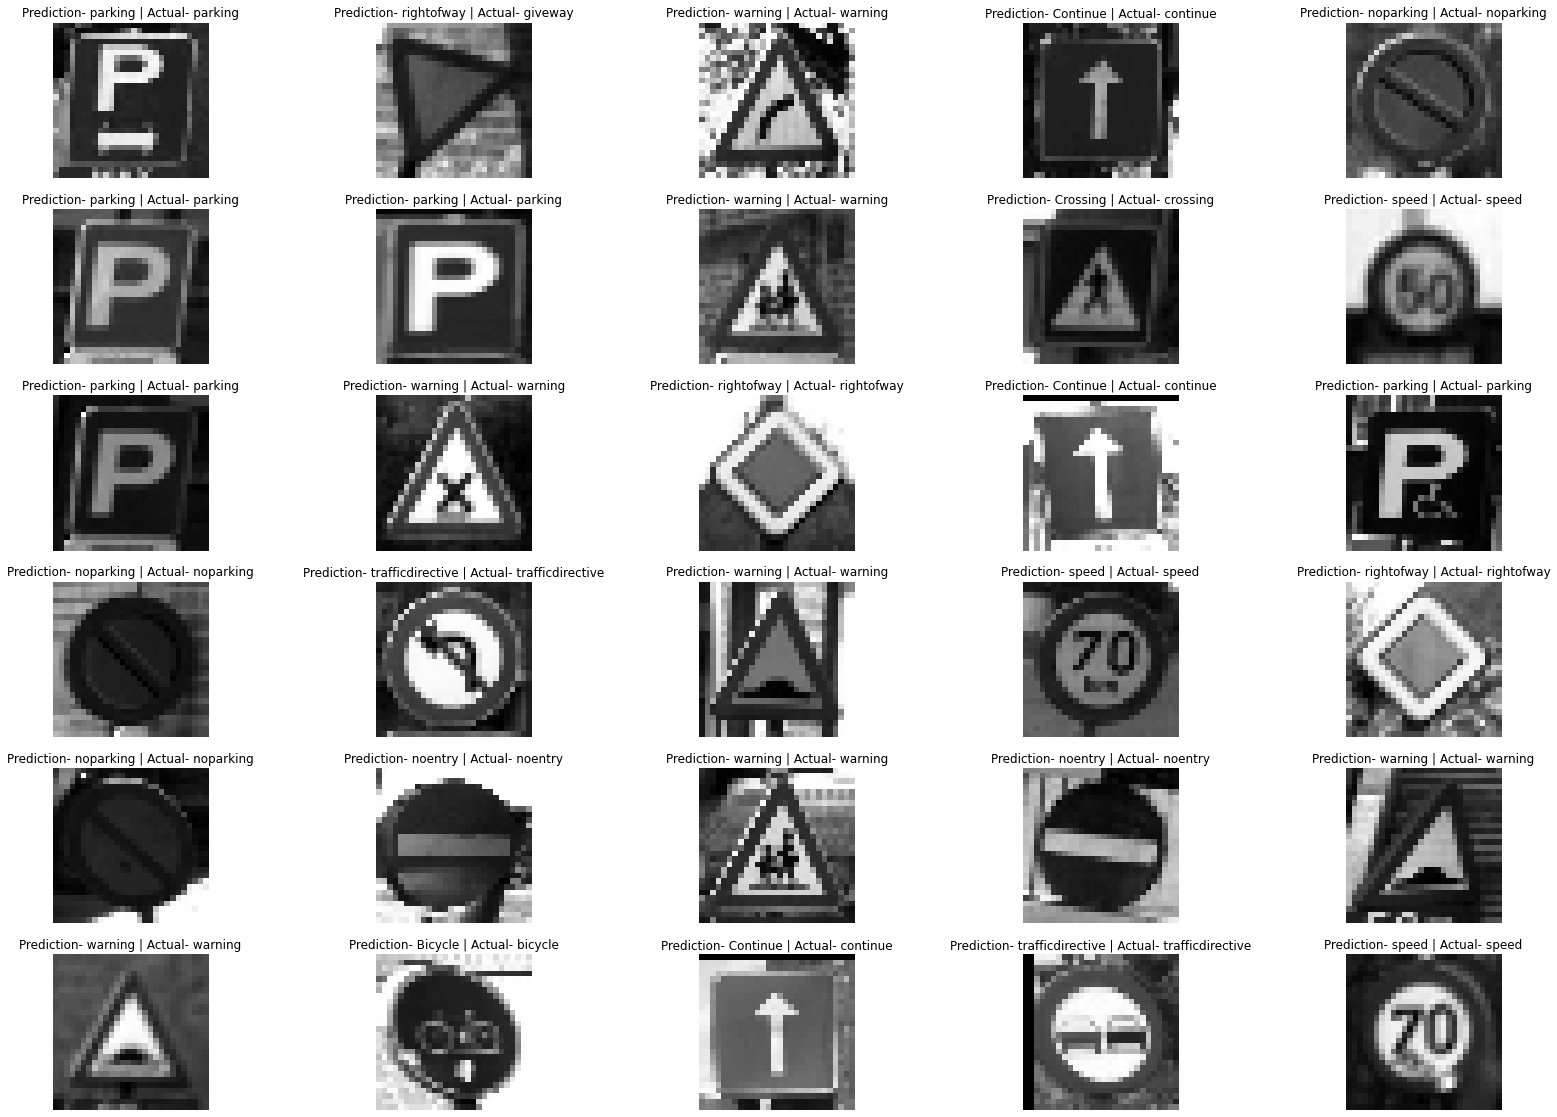

In [17]:
from keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

model = load_model('sign-classifier.h5')

classes = { 0:'Bicycle', 1:'Continue', 2:'Crossing', 3:'Giveway', 4:'Laneend', 5: 'limitedtraffic', 6: 'noentry', 7: 'noparking', 8: 'parking', 9: 'rightofway', 10: 'roundabout', 11: 'speed', 12: 'stop', 13: 'trafficdirective', 14: 'traveldirection', 15: 'warning' }
features_test1 = np.squeeze(features_test)

row_show, col_show = [6, 5]
fig, ax = plt.subplots(row_show, col_show, figsize=(28,20))
ax = ax.ravel()

for i in range(row_show * col_show):
    prediction = classifier.predict_classes(features_test)[i]
    prediction = np.asscalar(prediction)
    ax[i].axis('off')
    ax[i].set_title("Prediction- " + classes[prediction] + ' | ' + "Actual- " + CATEGORIES[labels_test[i]])
    ax[i].imshow(features_test1[i], cmap="gray")

# Data Augmentation

In [0]:
import random
import cv2

sign_count = np.bincount(np.sort(labels_train))
aug_factor = 3
augments = np.float32(((np.max(sign_count) * aug_factor) - sign_count)/sign_count)

def augment_dataset(x, y):
    augment_tally = np.zeros_like(augments)
    augmented = []
    augmentedLabels = []
    for i in range(len(x)):
        label = y[i]
        
        augment_tally[label] += augments[label]
        number_to_augment = np.int8(augment_tally[label])
        augment_tally[label] -= number_to_augment
        
        for j in range(number_to_augment):
            img = x[i].copy()

            # Scaling the image. Using a random scaling factor between .9 and 1.1
            rows, cols = img.shape[:2]
            scale_factor = random.uniform(.9, 1.1)
            interpolation = cv2.INTER_LINEAR
            if scale_factor < 1.0:
                interpolation = cv2.INTER_AREA
            dst = cv2.resize(img, (int(scale_factor*cols), int(scale_factor*rows)), interpolation = interpolation)
            if scale_factor < 1.0:
                img = cv2.resize(dst, (img.shape[1], img.shape[0]), interpolation = interpolation)            
            else:
                img = dst[:32, :32]

            # Translating the image a random amount between -2 and 2 pixels in the x and y directions
            x_trans = random.uniform(-2, 2)
            y_trans = random.uniform(-2, 2)
            M = np.float32([[1, 0, x_trans],[0, 1, y_trans]])
            img = cv2.warpAffine(img,M,(cols,rows))

            # Rotating the image. Using a random angle between -15 and 15 degrees.
            angle = random.uniform(-15, 15)
            M = cv2.getRotationMatrix2D(((cols-1)/2.0, (rows-1)/2.0), angle, 1)
            img = cv2.warpAffine(img, M, (cols,rows))

            # Add the new image and its label to the augmented list
            augmented.append(img)
            augmentedLabels.append(label)
        
    return augmented, augmentedLabels

In [19]:
# augmenting training data
x_augmented1, y_augmented1 = augment_dataset(features_train, labels_train)
x_augmented1 = np.array(x_augmented1).reshape(-1, 28, 28, 1)
features_aug_train = np.concatenate((features_train, x_augmented1))
labels_aug_train = np.concatenate((labels_train, y_augmented1))

print("--------------------------------------------------------------------------")
print("Number of training features/images: =", features_aug_train.shape[0])
print("Number of training labels =", np.unique(labels_aug_train).shape[0])
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Number of training features/images: = 24909
Number of training labels = 16
--------------------------------------------------------------------------


## Distribution after data augmentation

------------------------------
Categories          Counts
------------------------------
bicycle             1557
giveway             1557
parking             1557
roundabout          1557
traveldirection     1557
crossing            1557
noparking           1557
continue            1557
limitedtraffic      1557
warning             1557
speed               1557
noentry             1557
stop                1557
rightofway          1556
trafficdirective    1556
laneend             1556
Name: CATEGORIES, dtype: int64
------------------------------


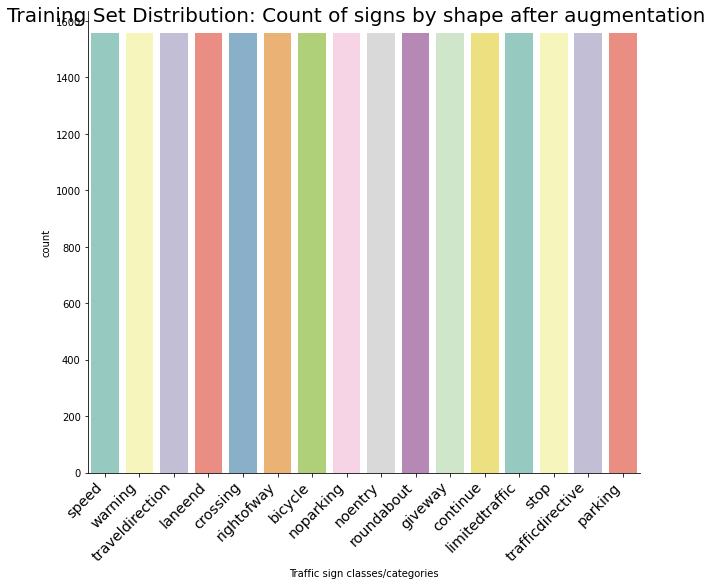

In [20]:
plot_sns_histogram(labels_aug_train, CATEGORIES, 'Training Set Distribution: Count of signs by shape after augmentation')

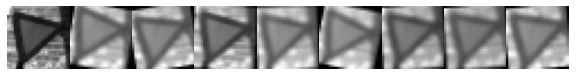

In [21]:
features_test1 = np.squeeze(features_test)
sample_aug = np.array([features_test1[1]])
sample_aug_labels = np.zeros(shape=(1,), dtype=np.int8)
augments = [8]
a, l = augment_dataset(sample_aug, sample_aug_labels)

sample_aug = np.concatenate((sample_aug, a))
set_labels = np.concatenate((sample_aug_labels, l))


fig, axes = plt.subplots(1, len(sample_aug), figsize=(12, 8))
for i in range(len(sample_aug)):
       axes[i].axis('off') 
       axes[i].imshow(sample_aug[i], cmap="gray")

        
plt.subplots_adjust(left=0.1, right=.75, bottom=0.0, wspace=0.0, hspace=0.0)
plt.show()


## Configuration and execution pipeline with augmented data

In [0]:
# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Conv2D(64, (3, 3), input_shape = (28, 28, 1), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 256, activation = 'relu'))
classifier.add(Dense(16, activation='softmax'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# Fitting the model to train the classifier with augmented data

In [23]:
history1 = classifier.fit(features_aug_train, labels_aug_train, batch_size=64, epochs=15, validation_data=(features_val, labels_val))
classifier.save("sign-classifier-aug.h5")

Train on 24909 samples, validate on 556 samples
Epoch 1/15
24909/24909 [==============================] - 2s 66us/step - loss: 0.6906 - accuracy: 0.7971 - val_loss: 0.1658 - val_accuracy: 0.9496
Epoch 2/15
24909/24909 [==============================] - 2s 61us/step - loss: 0.1412 - accuracy: 0.9585 - val_loss: 0.0698 - val_accuracy: 0.9802
Epoch 3/15
24909/24909 [==============================] - 2s 61us/step - loss: 0.0721 - accuracy: 0.9782 - val_loss: 0.0886 - val_accuracy: 0.9730
Epoch 4/15
24909/24909 [==============================] - 2s 61us/step - loss: 0.0421 - accuracy: 0.9867 - val_loss: 0.0504 - val_accuracy: 0.9838
Epoch 5/15
24909/24909 [==============================] - 1s 60us/step - loss: 0.0313 - accuracy: 0.9903 - val_loss: 0.0756 - val_accuracy: 0.9748
Epoch 6/15
24909/24909 [==============================] - 2s 60us/step - loss: 0.0199 - accuracy: 0.9943 - val_loss: 0.0670 - val_accuracy: 0.9838
Epoch 7/15
24909/24909 [==============================] - 2s 61us/step

In [24]:
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               409856    
_________________________________________________________________
dense_4 (Dense)              (None, 16)               

## Visualizing training-validation accuracy and training loss with augmented data

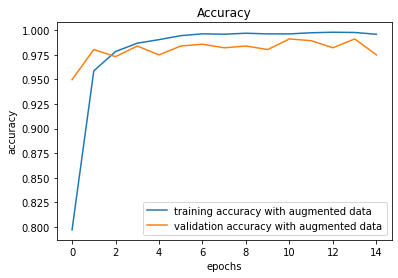

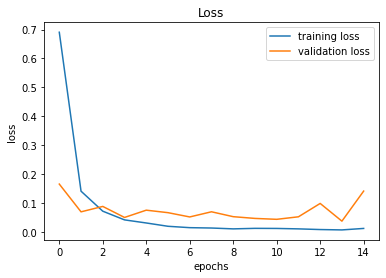

In [25]:
plt.plot(history1.history['accuracy'], label='training accuracy with augmented data')
plt.plot(history1.history['val_accuracy'], label='validation accuracy with augmented data')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot(history1.history['loss'], label='training loss')
plt.plot(history1.history['val_loss'], label='validation loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## Prediction accuracy

In [26]:
from sklearn.metrics import accuracy_score

pred = classifier.predict_classes(features_test)
print(accuracy_score(labels_test, pred))

0.9946236559139785


## Analysis report

In [27]:
# Look at accuracy on test dataset by class label
import itertools
import numpy as np
from sklearn.metrics import classification_report

# print(len(labels_test), len(pred))
# print(labels_test[:10], pred[:10])
print("------------------------------------------------------")
print(classification_report(labels_test, pred))
print("------------------------------------------------------")

------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00        23
           4       1.00      1.00      1.00        10
           5       0.91      0.91      0.91        11
           6       1.00      1.00      1.00        32
           7       1.00      1.00      1.00        26
           8       1.00      1.00      1.00        32
           9       0.97      1.00      0.98        28
          10       1.00      1.00      1.00         9
          11       1.00      1.00      1.00        42
          12       1.00      1.00      1.00         4
          13       1.00      0.96      0.98        25
          14       1.00      1.00      1.00        14
          15       1.00      1.00      1.00        66

    accuracy             

# Independent Evaluation

### Loading the Evaluation Dataset

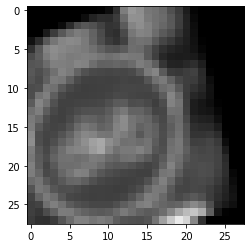

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

DATADIR = "/content/drive/My Drive/ML-Assignment/evaluation-sign-data"
CATEGORIES = ["bicycle", "continue", "crossing", "giveway", "laneend", "limitedtraffic", "noentry", "noparking", "parking", "rightofway", "roundabout", "speed", "stop", "trafficdirective", "traveldirection", "warning"]

for category in CATEGORIES:
  path = os.path.join(DATADIR, category)
  for img in os.listdir(path):
    #Grayscale to make the array 2D
    img_array = cv2.imread(os.path.join(path, img))
    plt.imshow(img_array)
    plt.show()
    break
  break

### Appending images and labels to an array

In [7]:
evaluation_data = []
IMG_SIZE = 28

def create_evaluation_data():
  for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    print(category)
    for img in os.listdir(path):
      class_num = CATEGORIES.index(category)
      img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
      new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
      evaluation_data.append([new_array, class_num])
      
create_evaluation_data()

bicycle
continue
crossing
giveway
laneend
limitedtraffic
noentry
noparking
parking
rightofway
roundabout
speed
stop
trafficdirective
traveldirection
warning


In [8]:
print(len(evaluation_data))

160


### Pickle data

In [0]:
import random
# Shuffling the data
random.shuffle(evaluation_data)

X = []
y = []
IMG_SIZE = 28

for features, label in evaluation_data:
  X.append(features)
  y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)

In [10]:
print(X.shape)

(160, 28, 28, 1)


In [0]:
import pickle

pickle_out = open("evaluation-features-sign.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("evaluation-labels-sign.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

## Importing pickle files

---

Run everthing from here, upload the pickle files if using google colab, or save the pickle files in the same directory and run the following notebook cells

---


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

# Classes/categories to which all the images belong
CATEGORIES = ["bicycle", "continue", "crossing", "giveway", "laneend", "limitedtraffic", "noentry", "noparking", "parking", "rightofway", "roundabout", "speed", "stop", "trafficdirective", "traveldirection", "warning"]

pickle_in = open("evaluation-features-sign.pickle", "rb")
featuresEvaluation = pickle.load(pickle_in)

pickle_in = open("evaluation-labels-sign.pickle", "rb")
labelsEvaluation = pickle.load(pickle_in)

# Final Evaluation

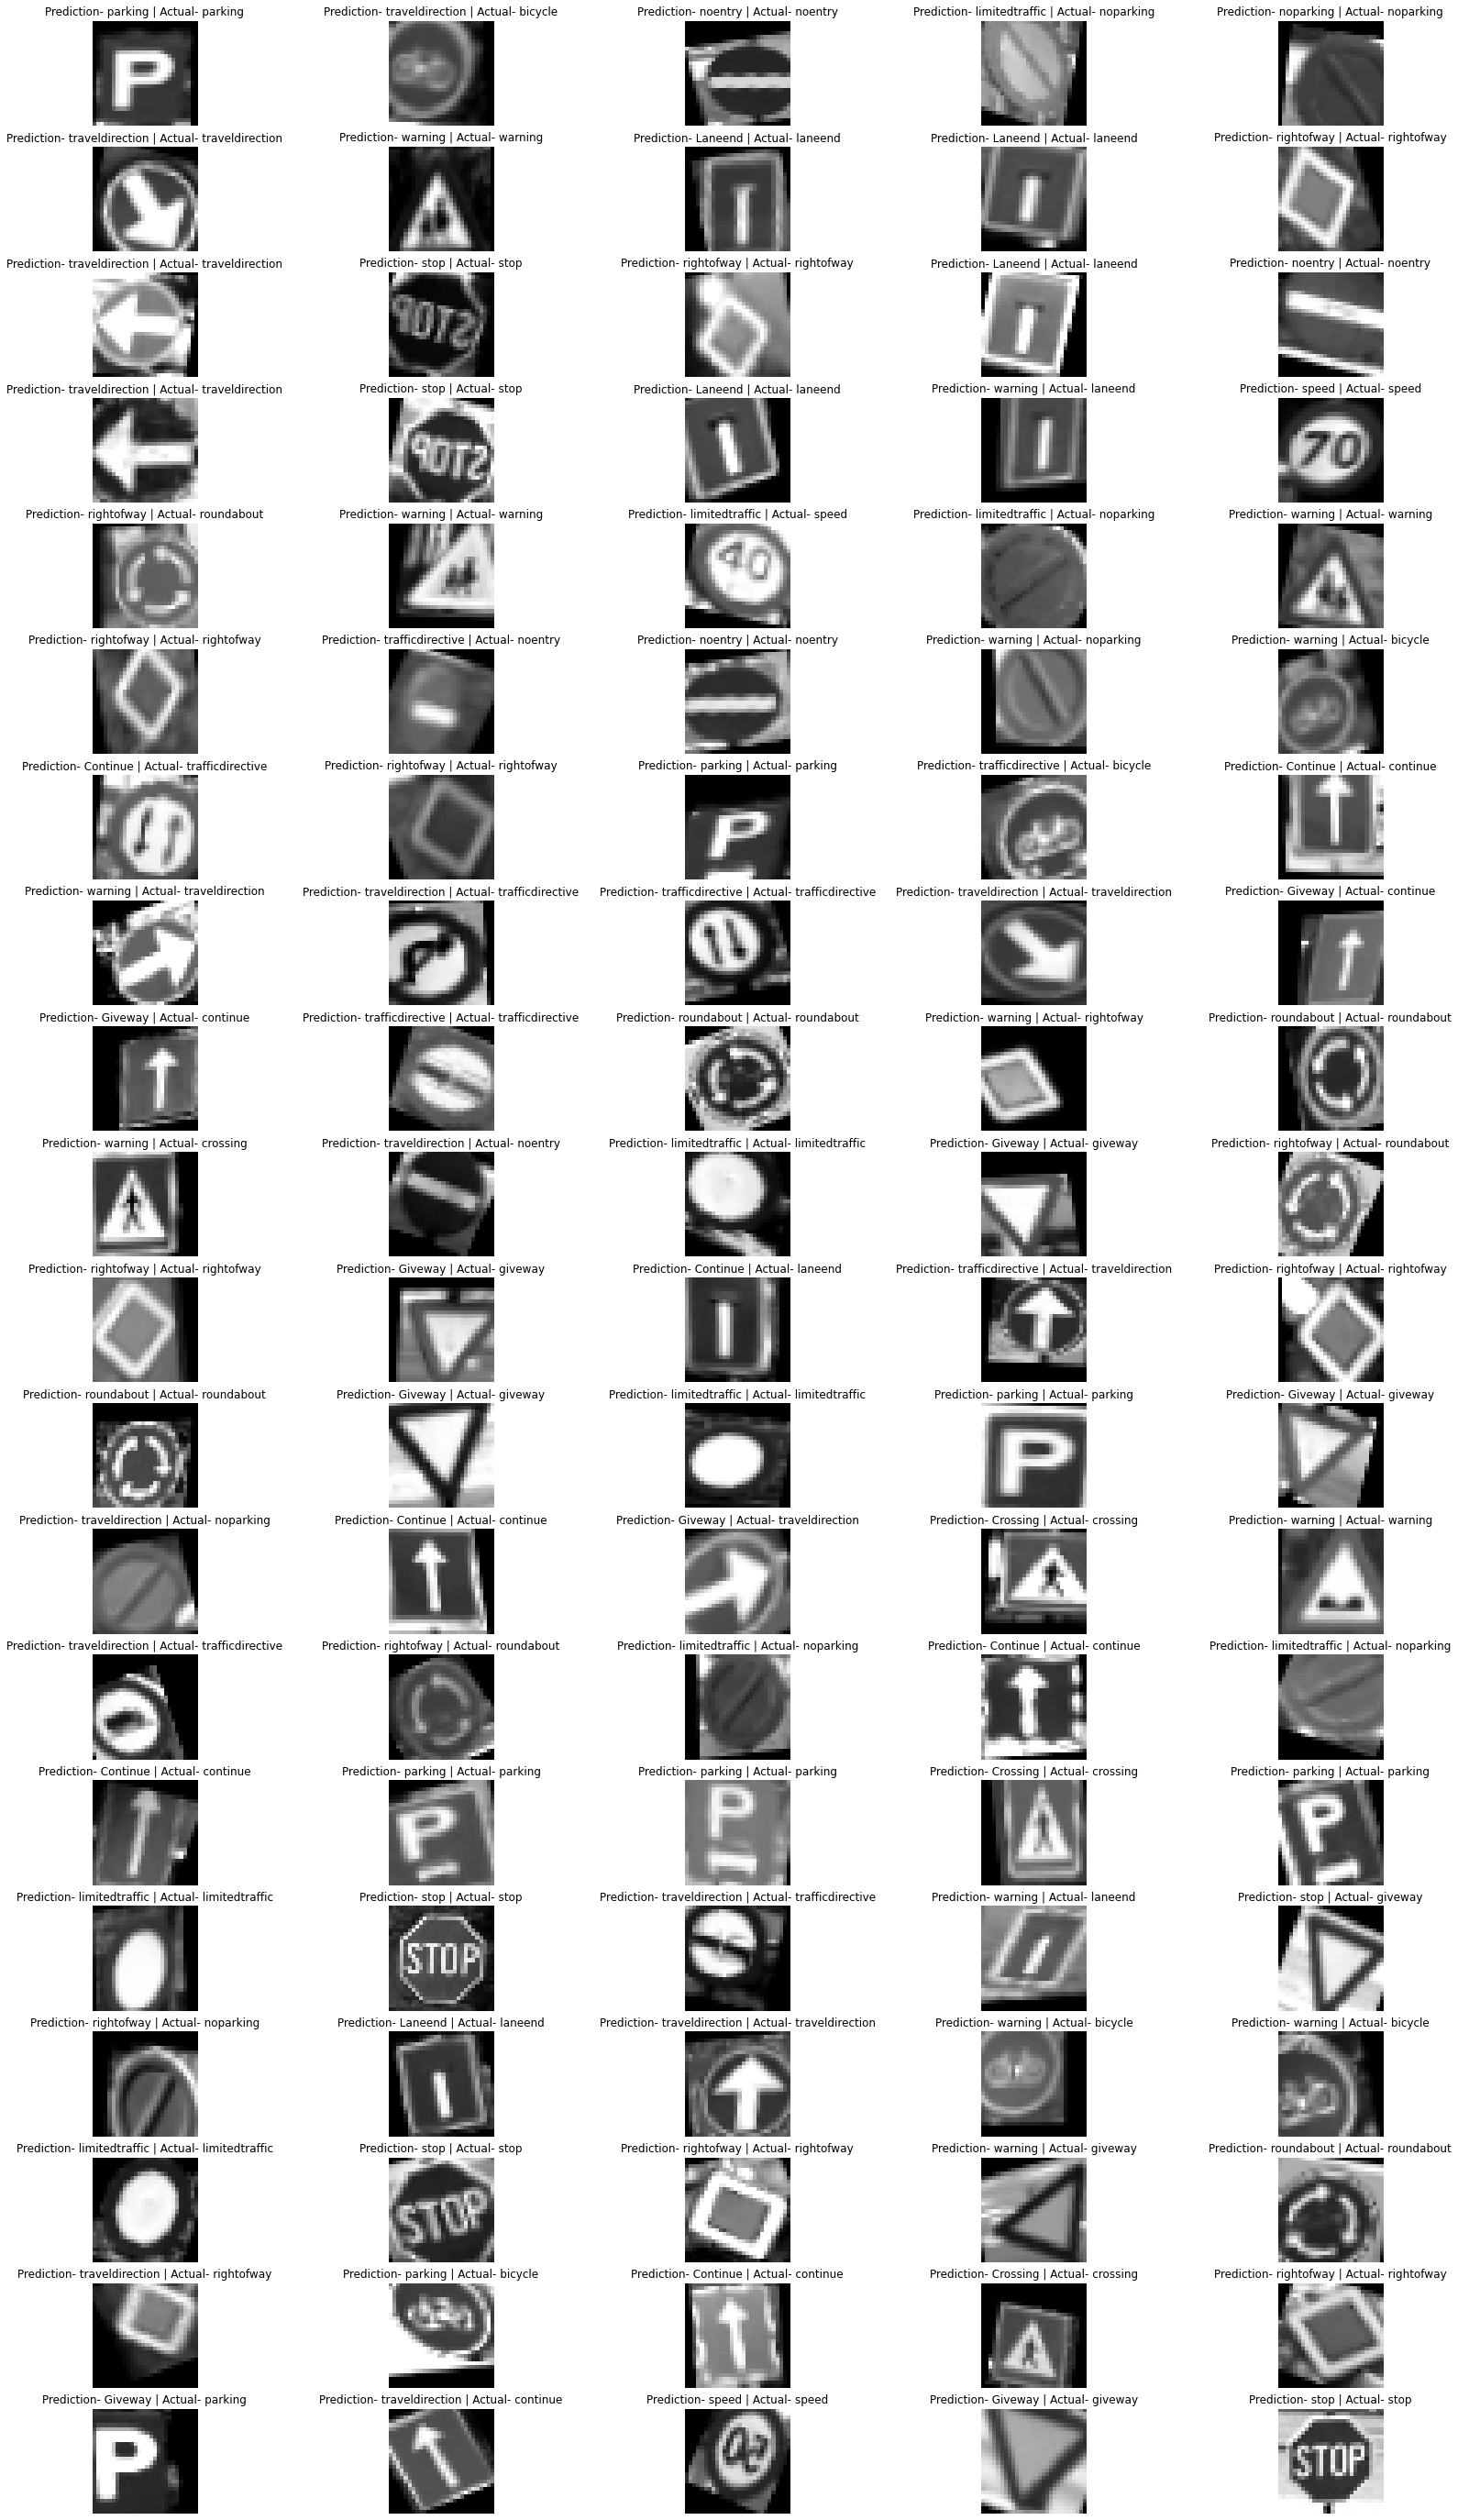

In [29]:
from keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

model = load_model('sign-classifier-aug.h5')

classes = { 0:'Bicycle', 1:'Continue', 2:'Crossing', 3:'Giveway', 4:'Laneend', 5: 'limitedtraffic', 6: 'noentry', 7: 'noparking', 8: 'parking', 9: 'rightofway', 10: 'roundabout', 11: 'speed', 12: 'stop', 13: 'trafficdirective', 14: 'traveldirection', 15: 'warning' }
featuresEvaluation1 = np.squeeze(featuresEvaluation)

row_show, col_show = [20, 5]
fig, ax = plt.subplots(row_show, col_show, figsize=(28,50))
ax = ax.ravel()

for i in range(row_show * col_show):
    prediction = classifier.predict_classes(featuresEvaluation)[i]
    prediction = np.asscalar(prediction)
    ax[i].axis('off')
    ax[i].set_title("Prediction- " + classes[prediction] + ' | ' + "Actual- " + CATEGORIES[labelsEvaluation[i]])
    ax[i].imshow(featuresEvaluation1[i], cmap="gray")

In [30]:
from sklearn.metrics import accuracy_score

pred = classifier.predict_classes(featuresEvaluation)
print(accuracy_score(labelsEvaluation, pred))

0.6125
